In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime, timedelta, timezone
import os
import glob
import re
import shutil
import pickle
from utility import read_timestamp, generate_info, get_candlist
import warnings
from matplotlib.patches import PathPatch
warnings.filterwarnings("ignore")
import utility

C:\Users\s3928927\.conda\envs\eeg\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\s3928927\.conda\envs\eeg\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\s3928927\.conda\envs\eeg\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [7]:
meta_eoi = ['IN', 'QF',  'QS', 'RJ',]

colors = {'EYEOPEN':  '#00A0B0', 'BASELINE':  '#00A0B0', 'EYECLOSE':  '#00A0B0',
 'IN': '#6A4A3C', '
 'QF': '#cc333f',
 'QS': '#eb6841',
 'RJ': '#edc951',
 'READ': '#a58c38',
 'LISTEN': '#f2d985',
 'SPEAK': '#a4482d', 'TYPE': '#ef8666'}


boxprops={
    'palette': colors,
     'flierprops': {"marker": "x"},
    'boxprops': {"edgecolor": "white"},
     'medianprops':{"color": "white", "linewidth": 1.5},
}


SMALL_SIZE = 13
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Analysis

In [3]:
df = pd.read_csv('../results/aggregated_pupil_first10s.csv', index_col=0)
df = df[(df.meta_cond != '+1') & (df.meta_cond != 'EYEOPEN')]
df

,pid,topic,cond,meta_cond,RPD,RPD_onset,onset,interp_ratio
0,PA18,419.0,READ,RJ,-0.022230,-0.077702,0.055473,0.038462
1,PA18,708.0,READ,RJ,-0.032803,0.021848,-0.054651,0.021661
2,PA18,416.0,READ,RJ,-0.051713,-0.053077,0.001364,0.029091
3,PA18,355.0,READ,RJ,-0.075339,-0.192710,0.117371,0.034749
4,PA18,708.0,IN,IN,-0.034835,0.019816,-0.054651,0.033333
...,...,...,...,...,...,...,...,...
650,PA15,711.0,QF,QF,0.058052,0.078601,-0.020549,0.030733
651,PA15,314.0,QF,QF,0.079172,0.010578,0.068594,0.030380
652,PA15,355.0,SPEAK,QS,0.104367,-0.015001,0.119369,0.036364
653,PA15,725.0,TYPE,QS,0.284514,0.315470,-0.030956,0.108108


In [6]:
merge_df = df[['pid', 'RPD', 'meta_cond']]\
    .groupby(['pid', 'meta_cond',]).mean().reset_index(drop=False)
merge_df

,pid,meta_cond,RPD
0,PA10,IN,-0.026150
1,PA10,QF,-0.013539
2,PA10,QS,0.071109
3,PA10,RJ,-0.002092
4,PA11,IN,-0.048239
...,...,...,...
87,PA8,RJ,0.007514
88,PA9,IN,-0.005224
89,PA9,QF,0.038612
90,PA9,QS,0.043555


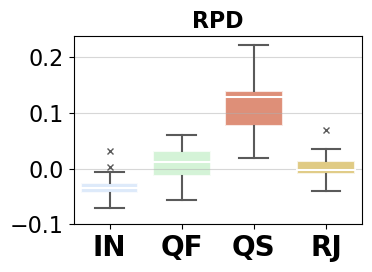

In [9]:
_, axes = plt.subplots(figsize=(4, 3))
sns.boxplot(data=merge_df, x='meta_cond', y='RPD', ax=axes, order=meta_eoi, **boxprops)
axes.grid(axis='y', alpha=0.5)
axes.set_xlabel(None)
axes.set_ylabel(None)
axes.set_yticks(np.arange(-0.1, 0.25, 0.1))
plt.title('RPD',weight='bold')

boxes = [child for child in axes.get_children() if isinstance(child, PathPatch)]
for i in boxes: 
    i.set_alpha(0.8)  
    
plt.xticks(fontweight='bold')

plt.tight_layout()
# plt.savefig('../results/RPD_all.pdf', dpi=500)
plt.show()


In [112]:
import pingouin as pg

tb = pg.pairwise_tests(dv='RPD', within='meta_cond', subject='pid', data=df, effsize='CLES', correction=False, parametric=False, return_desc=True)
tb.loc[:, 'p-corr'] = tb['p-unc'].values * 4
tb.loc[:, 'variable'] = 'RPD'
tb = tb.round(3)[['A', 'B', 'W-val', 'p-unc', 'p-corr', 'CLES', 'variable']]
tb.to_csv('../results/pupil_RPD_posthoc.csv')
tb

,A,B,W-val,p-unc,p-corr,CLES,variable
0,IN,QF,20.0,0.00,0.000,0.132,RPD
1,IN,QS,0.0,0.00,0.000,0.002,RPD
2,IN,RJ,15.0,0.00,0.000,0.119,RPD
3,QF,QS,0.0,0.00,0.000,0.028,RPD
4,QF,RJ,92.0,0.17,0.678,0.575,RPD
5,QS,RJ,1.0,0.00,0.000,0.989,RPD


## process pupil data

In [136]:
plist, candlist = get_candlist(exclude=['PA33', 'PA12', 'PA20'])
pinfos = generate_info(plist, exclude=None, parent_dir="../data")
pinfos

N. Selected Participants: 23 N. Selected Trials: 159
[5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24, 27, 28, 29, 30, 31, 32]
[('PA6', 314), ('PA7', 314), ('PA8', 314), ('PA9', 314), ('PA11', 314), ('PA13', 314), ('PA14', 314), ('PA15', 314), ('PA17', 314), ('PA18', 314), ('PA19', 314), ('PA24', 314), ('PA27', 314), ('PA28', 314), ('PA7', 320), ('PA8', 320), ('PA9', 320), ('PA10', 320), ('PA5', 320), ('PA11', 320), ('PA14', 320), ('PA18', 320), ('PA21', 320), ('PA22', 320), ('PA28', 320), ('PA30', 320), ('PA31', 320), ('PA32', 320), ('PA6', 353), ('PA8', 353), ('PA9', 353), ('PA14', 353), ('PA16', 353), ('PA17', 353), ('PA18', 353), ('PA22', 353), ('PA27', 353), ('PA28', 353), ('PA29', 353), ('PA30', 353), ('PA31', 353), ('PA7', 355), ('PA8', 355), ('PA9', 355), ('PA5', 355), ('PA11', 355), ('PA14', 355), ('PA15', 355), ('PA18', 355), ('PA19', 355), ('PA21', 355), ('PA22', 355), ('PA28', 355), ('PA29', 355), ('PA30', 355), ('PA31', 355), ('PA32', 355), ('PA6', 416), ('PA

{'PA18': {'pid': 'PA18',
  'folder_dir': '../data/PA18/processed/',
  'timestamp_file': '../data\\PA18\\events.csv',
  'tskey_file': '../data\\PA18\\timestamp_keys.pkl'},
 'PA30': {'pid': 'PA30',
  'folder_dir': '../data/PA30/processed/',
  'timestamp_file': '../data\\PA30\\events.csv',
  'tskey_file': '../data\\PA30\\timestamp_keys.pkl'},
 'PA5': {'pid': 'PA5',
  'folder_dir': '../data/PA5/processed/',
  'timestamp_file': '../data\\PA5\\events.csv',
  'tskey_file': '../data\\PA5\\timestamp_keys.pkl'},
 'PA6': {'pid': 'PA6',
  'folder_dir': '../data/PA6/processed/',
  'timestamp_file': '../data\\PA6\\events.csv',
  'tskey_file': '../data\\PA6\\timestamp_keys.pkl'},
 'PA17': {'pid': 'PA17',
  'folder_dir': '../data/PA17/processed/',
  'timestamp_file': '../data\\PA17\\events.csv',
  'tskey_file': '../data\\PA17\\timestamp_keys.pkl'},
 'PA32': {'pid': 'PA32',
  'folder_dir': '../data/PA32/processed/',
  'timestamp_file': '../data\\PA32\\events.csv',
  'tskey_file': '../data\\PA32\\timest

In [138]:
data = {}
max_duration=10

def cal_RPD(df, feature='pupil_norm'):
    baseline_pupil = np.nanmean(df[feature].values)
    df.loc[:, 'RPD'] = df[feature].apply(lambda x: (x-baseline_pupil)/baseline_pupil)
    return df

for p, files in pinfos.items():
    epochs, events = read_timestamp(files['timestamp_file'], files['tskey_file'])[2:]
    input_file = os.path.join(files['folder_dir'], 'pupil_clean.csv')
    df = pd.read_csv(input_file, index_col=0)
    df.loc[:, 'pupil'] = df.loc[:, 'smooth'].values
    df = cal_RPD(df, 'pupil')
    df.loc[:, 'pid'] = p
    df = utility.attach_info(p, df, epochs, events, candlist, plist, max_duration=None, baseline='EYEOPEN',)
    df = df[~df['cond'].isna()]
    data.update({p: {'epochs': epochs, 'time': events, 'pupil': df}})
    
print('Total Valid Data:', len(data))

Total Valid Data: 23


In [139]:
agg_df = []
max_duration = 10 

for p, temp in data.items():
    df = temp['pupil']
    df = df[df.cond != 'EYECLOSE']
    
    valid_topics = utility.cond_balance_topic(df)
    
    for (topic, cond) in df[['topic', 'cond']].value_counts().index:
        if (p, topic) not in valid: continue
        if topic not in valid_topics: continue
        if cond == '+1': continue  
        
        onset_baseline = df[(df.topic == topic) & (df.cond == '+1')]
        sec = onset_baseline.sec.max()
        onset_baseline = onset_baseline[onset_baseline.sec > (sec-2)].RPD.mean()

        selection = df[(df.topic == topic) & (df.cond == cond)]
        selection.loc[:, 'sec'] -= selection.sec.values[0]
        selection = selection[selection.sec < max_duration]
        ninterp = len(selection[selection.interpolated == 1])
        
        onset_changes = np.nanmean(selection.RPD) - onset_baseline
        
        val = [p, topic, cond, selection.meta_cond.values[0], np.nanmean(selection.RPD), onset_changes, onset_baseline, ninterp/len(selection)]
        agg_df.append(val)

agg_df = pd.DataFrame(agg_df, columns=['pid', 'topic', 'cond', 'meta_cond', 'RPD', 'RPD_onset', 'onset', 'interp_ratio'])
agg_df

,pid,topic,cond,meta_cond,RPD,RPD_onset,onset,interp_ratio
0,PA18,419.0,READ,RJ,-0.022230,-0.077702,0.055473,0.038462
1,PA18,708.0,READ,RJ,-0.032803,0.021848,-0.054651,0.021661
2,PA18,416.0,READ,RJ,-0.051713,-0.053077,0.001364,0.029091
3,PA18,355.0,READ,RJ,-0.075339,-0.192710,0.117371,0.034749
4,PA18,708.0,IN,IN,-0.034835,0.019816,-0.054651,0.033333
...,...,...,...,...,...,...,...,...
650,PA15,711.0,QF,QF,0.058052,0.078601,-0.020549,0.030733
651,PA15,314.0,QF,QF,0.079172,0.010578,0.068594,0.030380
652,PA15,355.0,SPEAK,QS,0.104367,-0.015001,0.119369,0.036364
653,PA15,725.0,TYPE,QS,0.284514,0.315470,-0.030956,0.108108


In [100]:
agg_df.meta_cond.value_counts()

meta_cond
RJ         158
IN         158
QS         158
QF         158
EYEOPEN     23
Name: count, dtype: int64

In [101]:
agg_df.to_csv('../results/aggregated_pupil_first10s.csv')